In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
import os

from DataGeneration import GenerateData

In [2]:
directory = os.getcwd()

X = np.load(directory + "/PodatkiK/intenziteta700noise0.npy")
Y = np.load(directory + "/PodatkiK/C_values.npy") / (300 * 1e-10)

In [8]:
#Ustvarimo funkcijo, ki vrača kompajlan model
def create_model(activation='sigmoid', optimizer='adam'):
    model = Sequential()
    model.add(Dense(units=400, 
                    activation=activation, 
                    input_shape=(400,), 
                    kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Dense(200, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error'])
    return model

In [4]:
from sklearn.model_selection import KFold

In [10]:
# Compute moving average
def moving_average(a, n=3) :
    
    idx = np.cumsum(np.arange(len(a)),dtype=float)
    idx[n:] = idx[n:] - idx[:-n]
    
    res = np.cumsum(a, dtype=float)
    res[n:] = res[n:] - res[:-n]
    
    return idx[n - 1:] / n, res[n - 1:] / n

In [11]:
num_folds = 3 # dolocimo st. foldov
kf = KFold(n_splits=num_folds, shuffle=True) # razred za razdelitev podatkov

fold_no = 1
scores_per_fold = []
verbose=0
losses = []
for train, test in kf.split(X[:10000], Y[:10000]): #zanka cez vse usne ter testne sete
    modelCV = create_model()
    history = modelCV.fit(X[train], Y[train], epochs=100, batch_size=100, verbose=verbose)
    
    # na fitanem modelu izvrednotimo mere uspesnosti
    # mere uspesnosti bi lahko spremljali ze tekom ucenja, znotraj metode fit
    scores = modelCV.evaluate(X[test], Y[test], verbose=verbose)
    print(f'Score per fold {fold_no}: {modelCV.metrics_names} of {scores}')
    scores_per_fold.append(scores)
    
    losses.append(moving_average(history.history['loss'], 40))
    fold_no += 1


Score per fold 1: ['loss', 'mean_squared_error'] of [0.08639360964298248, 0.03196880221366882]
Score per fold 2: ['loss', 'mean_squared_error'] of [0.08762812614440918, 0.0288811344653368]
Score per fold 3: ['loss', 'mean_squared_error'] of [0.09416124224662781, 0.03319723531603813]


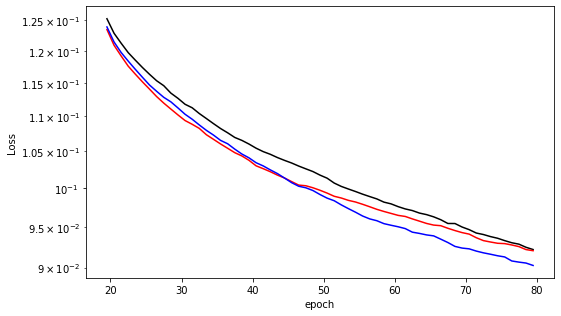

In [21]:
plt.figure(figsize=(7.5, 4.5))
colors=['k','r','b']
for i in range(3):
    plt.plot(losses[i][0], losses[i][1], c=colors[i])

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.tight_layout()
#plt.ylim([0, 0.005])
plt.yscale('log')
plt.show()
    

In [22]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # Wrapper za Keras model v sklearn

modelGS = KerasRegressor(build_fn=create_model, verbose=0, activation='relu') #ustvarimo model
#veljavni argumenti so argumenti funkcije create_model ter metode fit za Keras model

# najprej dolocimo optimalen batch_size ter stevilo epoh
# uspesnot modela ovrednotimo na vseh kombinacijah parametrov
batch_size = [50, 100] # vrednosti, ki jih preverimo
epochs = [50, 100]

# ustvarimo slovar kjer so kljuci imena parametrov
param_grid = dict(batch_size=batch_size, epochs=epochs)

#ustvarimo objekt z iskanje na mrezi
# specificiramo katero mero uspesnosti gledamo, default je loss funkcija
grid = GridSearchCV(estimator=modelGS, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')



In [23]:
grid.fit(X[:10000], Y[:10000])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000020E4E802888>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [50, 100], 'epochs': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [24]:
print("Best: %f using %s" %(grid.best_score_, grid.best_params_))
# pogledamo se rezultate v ostalih tockah
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with : %r' %(mean, stdev, param))

Best: -0.012135 using {'batch_size': 50, 'epochs': 100}


In [29]:
# Primer ko iscemo optimalen optimizator in aktivacijsko funkcijo
# uporabimo optimalen batch size in st. epoh
modelGS2 = KerasRegressor(build_fn=create_model, epochs=100, batch_size=50, verbose=0)
#
activation=['linear', 'relu', 'sigmoid']
optimizer=['SGD', 'RMSprop', 'Adam']

param_grid = dict(activation=activation, optimizer=optimizer)

#ustvarimo objekt z iskanje na mrezi
# specificiramo katero mero uspesnosti gledamo, default je loss funkcija
grid = GridSearchCV(estimator=modelGS2, param_grid=param_grid, n_jobs=-1, cv=3)


In [30]:
grid_result = grid.fit(X[:10000], Y[:10000])

In [31]:
print("Best: %f using %s" %(grid.best_score_, grid.best_params_))
# pogledamo se rezultate v ostalih tockah
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with : %r' %(mean, stdev, param))

Best: -0.072533 using {'activation': 'sigmoid', 'optimizer': 'Adam'}
-0.179049 (0.004195) with : {'activation': 'linear', 'optimizer': 'SGD'}
-0.180228 (0.000791) with : {'activation': 'linear', 'optimizer': 'RMSprop'}
-0.182313 (0.004303) with : {'activation': 'linear', 'optimizer': 'Adam'}
-0.087251 (0.009198) with : {'activation': 'relu', 'optimizer': 'SGD'}
-0.217051 (0.198222) with : {'activation': 'relu', 'optimizer': 'RMSprop'}
-0.205938 (0.206071) with : {'activation': 'relu', 'optimizer': 'Adam'}
-0.179164 (0.001185) with : {'activation': 'sigmoid', 'optimizer': 'SGD'}
-0.072932 (0.006052) with : {'activation': 'sigmoid', 'optimizer': 'RMSprop'}
-0.072533 (0.010631) with : {'activation': 'sigmoid', 'optimizer': 'Adam'}
